# SYMFLUENCE Tutorial 02a — Basin-Scale Workflow (Bow River at Banff, Lumped)

## Introduction

This tutorial demonstrates basin-scale hydrological modeling using SYMFLUENCE's lumped representation approach. Building on the point-scale workflows from Tutorials 01a and 01b, we now simulate streamflow from an entire watershed—the Bow River at Banff in the Canadian Rockies.

A lumped basin model treats the watershed as a single computational unit, spatially averaging all characteristics across the catchment. This simplified approach provides computational efficiency ideal for calibration and establishes baseline performance before adding spatial complexity.

The **Bow River at Banff** watershed encompasses ~2,210 km² with elevations from 1,384 m to over 3,400 m. Water Survey of Canada station 05BB001 provides streamflow observations for model evaluation. This snow-dominated mountain system presents strong elevation gradients, complex snow dynamics, and pronounced spring freshet periods.

Through this tutorial, you will see how the same SYMFLUENCE workflow scales seamlessly from point validation to basin prediction: configuration → domain → data → model → evaluation.


# Step 1 — Configuration

We generate a basin-scale configuration that specifies the lumped representation approach, gauging station coordinates, and watershed delineation method.

In [1]:
# Step 1 — Create basin-scale configuration

from pathlib import Path
import yaml
import sys
sys.path.append(str(Path("../..").resolve()))
from symfluence import SYMFLUENCE


SYMFLUENCE_CODE_DIR = Path("../../").resolve()

# Load template configuration
config_template = SYMFLUENCE_CODE_DIR / '0_config_files' / 'config_template.yaml'
with open(config_template, 'r') as f:
    config = yaml.safe_load(f)

# === Modify key entries for Bow River lumped basin ===
config['DOMAIN_NAME'] = 'Bow_at_Banff_lumped'
config['EXPERIMENT_ID'] = 'run_1'

# Gauging station coordinates (Banff WSC 05BB001)
config['POUR_POINT_COORDS'] = '51.1722/-115.5717'

# Lumped basin settings
config['DOMAIN_DEFINITION_METHOD'] = 'lumped'
config['DOMAIN_DISCRETIZATION'] = 'GRUs'

# Model configuration
config['HYDROLOGICAL_MODEL'] = 'SUMMA'
config['ROUTING_MODEL'] = 'mizuRoute'

# Temporal extent
config['EXPERIMENT_TIME_START'] = '2004-01-01 01:00'
config['EXPERIMENT_TIME_END'] = '2007-12-31 23:00'
config['CALIBRATION_PERIOD'] = '2005-10-01, 2006-09-30'
config['EVALUATION_PERIOD'] = '2006-10-01, 2007-10-30'
config['SPINUP_PERIOD'] = '2004-01-01, 2005-09-30'

# Streamflow observations
config['STATION_ID'] = '05BB001'
config['DOWNLOAD_WSC_DATA'] = True

# Basic optimization knobs if desired (example only)
config['PARAMS_TO_CALIBRATE'] = 'minStomatalResistance,cond2photo_slope,vcmax25_canopyTop,jmax25_scale,summerLAI,rootingDepth,soilStressParam,z0Canopy,windReductionParam'
config['OPTIMISATION_TARGET'] = 'streamflow'
config['ITERATIVE_OPTIMIZATION_ALGORITHM'] = 'DDS'
config['OPTIMIZATION_METRIC'] = 'KGE'
config['CALIBRATION_TIMESTEP'] = 'hourly'  

# Save configuration
config_path = SYMFLUENCE_CODE_DIR / '0_config_files' / 'config_basin_lumped.yaml'
with open(config_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False, sort_keys=False)

print(f"✅ Configuration saved: {config_path}")

# Initialize SYMFLUENCE
symfluence = SYMFLUENCE(config_path)

# Create project structure
project_dir = symfluence.managers['project'].setup_project()
pour_point_path = symfluence.managers['project'].create_pour_point()

print(f"✅ Project structure created at: {project_dir}")

✅ Configuration saved: /Users/darrieythorsson/compHydro/code/SYMFLUENCE/0_config_files/config_basin_lumped.yaml
2025-11-18 16:26:17 ● SYMFLUENCE Logging Initialized
2025-11-18 16:26:17 ● Domain: Bow_at_Banff_lumped
2025-11-18 16:26:17 ● Experiment ID: run_1
2025-11-18 16:26:17 ● Log Level: INFO
2025-11-18 16:26:17 ● Log File: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/_workLog_Bow_at_Banff_lumped/symfluence_general_Bow_at_Banff_lumped_20251118_162617.log
2025-11-18 16:26:17 ● Configuration logged to: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/_workLog_Bow_at_Banff_lumped/config_Bow_at_Banff_lumped_20251118_162617.yaml
2025-11-18 16:26:17 ● SYMFLUENCE initialized with config: /Users/darrieythorsson/compHydro/code/SYMFLUENCE/0_config_files/config_basin_lumped.yaml
2025-11-18 16:26:17 ● Setting up project for domain: Bow_at_Banff_lumped
2025-11-18 16:26:17 ● Project directory created at: /Users/darrieythorsson/com

## Step 2 — Domain definition

For basin-scale modeling, we delineate the watershed boundary and create a single lumped HRU representing the entire catchment.

### Step 2a — Geospatial attribute acquisition - **Only available through MAF supported HPCs**

Acquires watershed attributes (elevation, land cover, soils) that will be spatially averaged for the lumped representation.

- If using downloaded example data, copy attributes, forcing, and observation directories into the domain directory from Step 1

In [ ]:
# Step 2a — Attribute acquisition
# If using MAF supported HPC, uncomment the line below
# symfluence.managers['data'].acquire_attributes()
print("✅ Attribute acquisition complete")

### Step 2b — Watershed delineation

Delineates the basin boundary using automated watershed analysis from the pour point coordinates.

In [2]:
# Step 2b — Watershed delineation
watershed_path = symfluence.managers['domain'].define_domain()
print("✅ Watershed delineation complete")
print(f"Watershed file: {watershed_path}")

2025-11-18 16:26:22 ● Domain definition workflow starting with: lumped
2025-11-18 16:26:22 ● Starting lumped watershed delineation for Bow_at_Banff_lumped
PitRemove version 5.4.0
Input file /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem/domain_Bow_at_Banff_lumped_elv.tif has geographic coordinate system.
Nodata value input to create partition from file: -9999.000000
Nodata value recast to float used in partition raster: -9999.000000


This run may take on the order of 2 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.


Processes: 1
Header read time: 0.149894
Data read time: 0.284093
Compute time: 4.014835
Write time: 1.032341
Total time: 5.481163
2025-11-18 16:26:28 ● Completed TauDEM step: mpirun -n 1 /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/installs/TauDEM/bin/pitremove -z /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem/domain_Bow_at_Banff_lumped_elv.tif -fel /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif
D8FlowDir version 5.4.0
Input file /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif has geographic coordinate system.
Nodata value input to create partition from file: -300000000549775575777803994281145270272.000000
Nodata value recast to float used in partition raster: -300000000549775575777803994281145270272.000000


This run may take on the order of 24 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
All slopes evaluated. 1072285 flats to resolve.
Draining flats towards lower adjacent terrain
..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Processors: 1
Header read time: 0.132155
Data read time: 0.303894
Compute Slope time: 3.087956
Write Slope time: 0.970744
Resolve Flat time: 97.314739
Write Flat time: 0.505797
Total time: 102.315285
2025-11-18 16:28:10 ● Completed TauDEM step: mpirun -n 1 /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/installs/TauDEM/bin/d8flowdir -fel /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif -p /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -sd8 /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/sd8.tif
AreaD8 version 5.4.0
Input file /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768


This run may take on the order of 2 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.


Number of Processes: 1
Read time: 0.194888
Compute time: 4.046371
Write time: 0.784775
Total time: 5.026034
2025-11-18 16:28:15 ● Completed TauDEM step: mpirun -n 1 /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/installs/TauDEM/bin/aread8 -p /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -ad8 /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif
Threshold version 5.4.0
Input file /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif has geographic coordinate system.
Nodata value input to create partition from file: -1.000000
Nodata value recast to float used in partition raster: -1.000000


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.


Compute time: 0.205093
2025-11-18 16:28:16 ● Completed TauDEM step: mpirun -n 1 /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/installs/TauDEM/bin/threshold -ssa /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif -src /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif -thresh 100
MoveOutletsToStreams version 5.4.0
Input file /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Input file /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.


om Total time: 0.361594
2025-11-18 16:28:17 ● Completed TauDEM step: mpirun -n 1 /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/installs/TauDEM/bin/moveoutletstostreams -p /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -src /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif -o /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/pour_point/Bow_at_Banff_lumped_pourPoint.shp -om /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/om.shp
Gage Watershed version 5.4.0
Input file /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768


This run may take on the order of 2 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.


Size: 1
Read time: 0.217978
Compute time: 0.398647
Write time: 0.384558
Total time: 1.001183
2025-11-18 16:28:18 ● Completed TauDEM step: mpirun -n 1 /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/installs/TauDEM/bin/gagewatershed -p /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -o /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/om.shp -gw /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/watershed.tif -id /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/watershed_id.txt
2025-11-18 16:28:22 ● Removed temporary file: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.dbf
2025-11-18 16:28:22 ● Removed temporary file: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domai

### Step 2c — Domain discretization

Creates a single HRU that represents the lumped basin with spatially-averaged characteristics.

In [3]:
# Step 2c — Discretization (single lumped HRU)
hru_path = symfluence.managers['domain'].discretize_domain()
print("✅ Domain discretization complete")
print(f"HRU file: {hru_path}")

2025-11-18 16:28:22 ● Discretizing domain using method: GRUs
2025-11-18 16:28:22 ● Starting domain discretization using attributes: ['GRUs']
Step 1/2: Running single attribute discretization method
2025-11-18 16:28:22 ● config domain name Bow_at_Banff_lumped
2025-11-18 16:28:22 ● Calculating mean elevation for each HRU
2025-11-18 16:28:22 ● DEM CRS: EPSG:4326
2025-11-18 16:28:22 ● Shapefile CRS: EPSG:4326
2025-11-18 16:28:22 ● CRS match - no reprojection needed
2025-11-18 16:28:22 ● Successfully calculated elevation statistics for 1 HRUs
2025-11-18 16:28:22 ● Calculated centroids in WGS84: lat range 51.360128 to 51.360128, lon range -116.010436 to -116.010436
2025-11-18 16:28:22 ● GRUs saved as HRUs to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment/Bow_at_Banff_lumped_HRUs_GRUs.shp
2025-11-18 16:28:23 ● HRU plot saved to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_lumped/plots/catchment/Bow_at_Banff_lu

### Step 2d — Visualization

Quick visualization of the lumped basin boundary and pour point location.

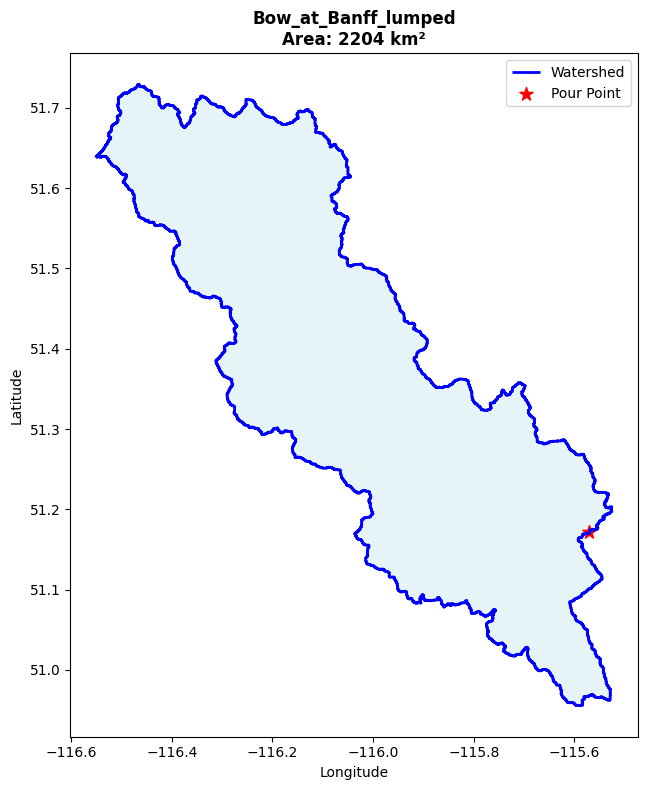

Watershed area: 2204 km²
Number of HRUs: 1 (lumped)


In [4]:
# Step 2d — Basin visualization

import geopandas as gpd
import matplotlib.pyplot as plt

# Load spatial data
basin_path = project_dir / 'shapefiles' / 'river_basins' / f"{config['DOMAIN_NAME']}_riverBasins_lumped.shp"
hru_file = project_dir / 'shapefiles' / 'catchment' / f"{config['DOMAIN_NAME']}_HRUs_GRUs.shp"

watershed_gdf = gpd.read_file(str(basin_path))
hru_gdf = gpd.read_file(str(hru_file))
pour_point_gdf = gpd.read_file(pour_point_path)

# Calculate area
watershed_proj = watershed_gdf.to_crs('EPSG:32611')  # UTM Zone 11N
area_km2 = watershed_proj.geometry.area.sum() / 1e6

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
watershed_gdf.boundary.plot(ax=ax, color='blue', linewidth=2, label='Watershed')
hru_gdf.plot(ax=ax, facecolor='lightblue', edgecolor='blue', alpha=0.3)
pour_point_gdf.plot(ax=ax, color='red', markersize=100, marker='*', label='Pour Point')

ax.set_title(f'{config["DOMAIN_NAME"]}\n'
             f'Area: {area_km2:.0f} km²', fontweight='bold')
ax.legend()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

print(f"Watershed area: {area_km2:.0f} km²")
print(f"Number of HRUs: {len(hru_gdf)} (lumped)")

## Step 3 — Data acquisition and preprocessing

Process streamflow observations, meteorological forcing data, and prepare model-ready inputs.

### Step 3a — Streamflow observations

Download and process Water Survey of Canada streamflow data for model evaluation.

In [ ]:
# Step 3a — Streamflow data processing
# If using MAF supported HPC, uncomment the line below
# symfluence.managers['data'].process_observed_data()
print("✅ Streamflow data processing complete")

### Step 3b — Meteorological forcing

Acquire and spatially average meteorological forcing data over the basin.

In [ ]:
# Step 3b — Forcing acquisition
# If using MAF supported HPC, uncomment the line below
# symfluence.managers['data'].acquire_forcings()
print("✅ Forcing acquisition complete")

### Step 3c — Model-agnostic preprocessing

Standardize variable names, units, and time steps for model consumption.

In [ ]:
# Step 3c — Model-agnostic preprocessing
symfluence.managers['data'].run_model_agnostic_preprocessing()
print("✅ Model-agnostic preprocessing complete")

## Step 4 — Model configuration and execution

Configure SUMMA for basin-scale simulation with mizuRoute routing, then execute the model.

In [ ]:
# Step 4a — SUMMA-specific preprocessing
symfluence.managers['model'].preprocess_models()
print("✅ Model configuration complete")

In [ ]:
# Step 4b — Model execution
print(f"Running {config['HYDROLOGICAL_MODEL']} with {config.get('ROUTING_MODEL', 'no routing')}...")
symfluence.managers['model'].run_models()
print("✅ Basin-scale simulation complete")

## Step 5 — Streamflow evaluation

Compare simulated and observed streamflow using standard hydrological metrics and visualization.

In [ ]:
# Step 5 — Streamflow evaluation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# Load basin area from shapefile
basin_path = project_dir / 'shapefiles' / 'river_basins' / f"{config['DOMAIN_NAME']}_riverBasins_lumped.shp"
watershed_gdf = gpd.read_file(str(basin_path))
watershed_proj = watershed_gdf.to_crs('EPSG:32611')  # UTM Zone 11N for accurate area calculation
basin_area_m2 = watershed_proj.geometry.area.sum()  # Basin area in m²
basin_area_km2 = basin_area_m2 / 1e6  # Basin area in km²

print(f"Basin area: {basin_area_km2:.2f} km²")

# Load observed streamflow
obs_path = project_dir / "observations" / "streamflow" / "preprocessed" / f"{config['DOMAIN_NAME']}_streamflow_processed.csv"
obs_df = pd.read_csv(obs_path, parse_dates=['datetime'])
obs_df.set_index('datetime', inplace=True)

# Load simulated streamflow from SUMMA output
routing_dir = project_dir / "simulations" / config['EXPERIMENT_ID'] / "SUMMA"
sim_files = list(routing_dir.glob('*_timestep.nc'))
if not sim_files:
    raise FileNotFoundError(f"No SUMMA output found in: {routing_dir}")

import xarray as xr
sim_ds = xr.open_dataset(sim_files[0])
sim_df = sim_ds['averageRoutedRunoff'].to_dataframe().reset_index()
sim_df = sim_df.rename(columns={'time': 'datetime', 'averageRoutedRunoff': 'discharge_m_s'})
sim_df.set_index('datetime', inplace=True)

# Convert from m/s to m³/s
sim_df['discharge_sim'] = sim_df['discharge_m_s'] * basin_area_m2

# Parse spinup period from config and exclude it
spinup_end = pd.to_datetime(config['SPINUP_PERIOD'].split(',')[1].strip())
print(f"Excluding spinup period up to: {spinup_end}")

# Merge and align, then filter out spinup period
eval_df = obs_df.join(sim_df[['discharge_sim']], how='inner')
eval_df = eval_df[eval_df.index > spinup_end]  # Exclude spinup period

obs_valid = eval_df['discharge_cms'].dropna()
sim_valid = eval_df.loc[obs_valid.index, 'discharge_sim']

print(f"Evaluation period: {obs_valid.index[0]} to {obs_valid.index[-1]}")
print(f"Number of timesteps: {len(obs_valid)}")

# Calculate evaluation metrics
def nse(obs, sim):
    return float(1 - np.sum((obs - sim)**2) / np.sum((obs - obs.mean())**2))

def kge(obs, sim):
    r = obs.corr(sim)
    alpha = sim.std() / obs.std()
    beta = sim.mean() / obs.mean()
    return float(1 - np.sqrt((r-1)**2 + (alpha-1)**2 + (beta-1)**2))

def pbias(obs, sim):
    return float(100 * (sim.sum() - obs.sum()) / obs.sum())

metrics = {
    'NSE': round(nse(obs_valid, sim_valid), 3),
    'KGE': round(kge(obs_valid, sim_valid), 3),
    'PBIAS': round(pbias(obs_valid, sim_valid), 1)
}

print("\nPerformance Metrics:")
for k, v in metrics.items():
    print(f"  {k}: {v}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series (top left)
axes[0, 0].plot(obs_valid.index, obs_valid.values, 'b-', label='Observed', linewidth=1.2, alpha=0.7)
axes[0, 0].plot(sim_valid.index, sim_valid.values, 'r-', label='Simulated', linewidth=1.2, alpha=0.7)
axes[0, 0].set_ylabel('Discharge (m³/s)')
axes[0, 0].set_title('Streamflow Time Series')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.02, 0.95, f"NSE: {metrics['NSE']}\nKGE: {metrics['KGE']}\nBias: {metrics['PBIAS']}%",
                transform=axes[0, 0].transAxes, verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8), fontsize=9)

# Scatter (top right)
axes[0, 1].scatter(obs_valid, sim_valid, alpha=0.5, s=10)
max_val = max(obs_valid.max(), sim_valid.max())
axes[0, 1].plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
axes[0, 1].set_xlabel('Observed (m³/s)')
axes[0, 1].set_ylabel('Simulated (m³/s)')
axes[0, 1].set_title('Observed vs Simulated')
axes[0, 1].grid(True, alpha=0.3)

# Monthly climatology (bottom left)
monthly_obs = obs_valid.groupby(obs_valid.index.month).mean()
monthly_sim = sim_valid.groupby(sim_valid.index.month).mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[1, 0].plot(monthly_obs.index, monthly_obs.values, 'b-o', label='Observed', markersize=6)
axes[1, 0].plot(monthly_sim.index, monthly_sim.values, 'r-o', label='Simulated', markersize=6)
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(month_names)
axes[1, 0].set_ylabel('Mean Discharge (m³/s)')
axes[1, 0].set_title('Seasonal Flow Regime')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Flow duration curve (bottom right)
obs_sorted = obs_valid.sort_values(ascending=False)
sim_sorted = sim_valid.sort_values(ascending=False)
obs_ranks = np.arange(1., len(obs_sorted) + 1) / len(obs_sorted) * 100
sim_ranks = np.arange(1., len(sim_sorted) + 1) / len(sim_sorted) * 100
axes[1, 1].semilogy(obs_ranks, obs_sorted, 'b-', label='Observed', linewidth=2)
axes[1, 1].semilogy(sim_ranks, sim_sorted, 'r-', label='Simulated', linewidth=2)
axes[1, 1].set_xlabel('Exceedance Probability (%)')
axes[1, 1].set_ylabel('Discharge (m³/s)')
axes[1, 1].set_title('Flow Duration Curve')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Lumped Basin Evaluation — {config["DOMAIN_NAME"]}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Streamflow evaluation complete")

# Step 5b — Run calibration 



In [ ]:
results_file = symfluence.managers['optimization'].calibrate_model()  
print("Calibration results file:", results_file)